In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

2024-04-29 00:32:26.873200: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-29 00:32:26.873753: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-29 00:32:26.876625: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-29 00:32:26.931407: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 00:32:27.685210: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

# Data PreProcessing

In [2]:
# importing dataset
train_data = pd.read_csv('trainset.csv')
train_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,357.385559,361.151062,355.959839,359.288177,359.288177,5115500
1,2013-01-03,360.122742,363.600128,358.031342,359.496826,359.496826,4666500
2,2013-01-04,362.313507,368.339294,361.488861,366.600616,366.600616,5562800
3,2013-01-07,365.348755,367.301056,362.929504,365.001007,365.001007,3332900
4,2013-01-08,365.393463,365.771027,359.874359,364.280701,364.280701,3373900


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1259 non-null   object 
 1   Open       1259 non-null   float64
 2   High       1259 non-null   float64
 3   Low        1259 non-null   float64
 4   Close      1259 non-null   float64
 5   Adj Close  1259 non-null   float64
 6   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


In [4]:
train_data = train_data.iloc[:, 1:2].values

In [5]:
train_data

array([[ 357.385559],
       [ 360.122742],
       [ 362.313507],
       ...,
       [1057.390015],
       [1051.599976],
       [1046.719971]])

# Feature Scaling

In [6]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
train_scaled = sc.fit_transform(train_data)

In [7]:
train_scaled

array([[0.01011148],
       [0.01388614],
       [0.01690727],
       ...,
       [0.97543954],
       [0.9674549 ],
       [0.96072522]])

#### Creating a data structure with 60 timesteps and 1 output

In [8]:
# This past time step is for rnn to learn from the previous 60 stock prices
# this is past information for rnn to learn
x_train = []
y_train = []
# lower_bound = 60
# upper_bound = 1259
for i in range(60, 1259):
    # (0, 59)
    x_train.append(train_scaled[i-60:i, 0])
    # append actual output
    y_train.append(train_scaled[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [9]:
x_train.shape, y_train.shape

((1199, 60), (1199,))

In [10]:
## reshaping dataset- because rnn takes input in 3-Dimension
x_train = x_train.reshape(1199, 60, 1)

In [11]:
x_train.shape

(1199, 60, 1)

# Building LSTM

#### Initialising RNN

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

model = Sequential()

In [13]:
# 1st Lstm layer
# 1.units(60): No. of cells or memory unit for LSTM layer
# 2.activation(relu): adds non-linearity to network
model.add(tf.keras.layers.LSTM(units=60, activation='relu', return_sequences=True, input_shape=(60,1)))
# dropout layer : regularisation techniue
model.add(Dropout(0.2))

/home/kalp/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
# 2nd layer
model.add(tf.keras.layers.LSTM(units=60, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

In [15]:
# 3rd layer
model.add(tf.keras.layers.LSTM(units=80, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

In [16]:
# 4th layer
model.add(tf.keras.layers.LSTM(units=120, activation='relu'))
model.add(Dropout(0.2))

In [17]:
## output layer
model.add(Dense(units = 1))

In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 60)         │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 60)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 60)         │        29,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 60)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 80)         │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 80)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 120)            │        96,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,641 (725.16 KB)

 Trainable params: 185,641 (725.16 KB)

 Non-trainable params: 0 (0.00 B)

### Model Compiling

In [19]:
model.compile(optimizer = "adam", loss = "mean_squared_error")

### Model Training 

In [21]:
model.fit(x_train, y_train, batch_size=32, epochs=10)

Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0036
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0037
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - loss: 0.0033
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 0.0035
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.0036
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.0031
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.0045
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 0.0034
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0034
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0031


# Making Predictions

In [22]:
## getting real stock prices
test_data = pd.read_csv('testset.csv')
test_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,1048.339966,1066.939941,1045.229980,1065.000000,1065.000000,1237600
1,2018-01-03,1064.310059,1086.290039,1063.209961,1082.479980,1082.479980,1430200
2,2018-01-04,1088.000000,1093.569946,1084.001953,1086.400024,1086.400024,1004600
3,2018-01-05,1094.000000,1104.250000,1092.000000,1102.229980,1102.229980,1279100
4,2018-01-08,1102.229980,1111.270020,1101.619995,1106.939941,1106.939941,1047600


In [23]:
test_data.shape

(125, 7)

In [24]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       125 non-null    object 
 1   Open       125 non-null    float64
 2   High       125 non-null    float64
 3   Low        125 non-null    float64
 4   Close      125 non-null    float64
 5   Adj Close  125 non-null    float64
 6   Volume     125 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 7.0+ KB


In [25]:
real_stock_price = test_data.iloc[:, 1:2].values
real_stock_price

array([[1048.339966],
       [1064.310059],
       [1088.      ],
       [1094.      ],
       [1102.22998 ],
       [1109.400024],
       [1097.099976],
       [1106.300049],
       [1102.410034],
       [1132.51001 ],
       [1126.219971],
       [1131.410034],
       [1131.829956],
       [1137.48999 ],
       [1159.849976],
       [1177.329956],
       [1172.530029],
       [1175.079956],
       [1176.47998 ],
       [1167.829956],
       [1170.569946],
       [1162.609985],
       [1122.      ],
       [1090.599976],
       [1027.180054],
       [1081.540039],
       [1055.410034],
       [1017.25    ],
       [1048.      ],
       [1045.      ],
       [1048.949951],
       [1079.069946],
       [1088.410034],
       [1090.569946],
       [1106.469971],
       [1116.189941],
       [1112.640015],
       [1127.800049],
       [1141.23999 ],
       [1123.030029],
       [1107.869995],
       [1053.079956],
       [1075.140015],
       [1099.219971],
       [1089.189941],
       [11

In [26]:
df_train = pd.read_csv('trainset.csv')
df_test = pd.read_csv('testset.csv')

In [27]:
# Getting predicted stock price

# test + train
total_dataset = pd.concat((df_train['Open'], df_test['Open']), axis=0)

# select 60 previous stock price for each day
inputs = total_dataset[len(total_dataset) - len(test_data) - 60:].values

# convert into np-array
inputs = inputs.reshape(-1,1)

# feature scaling
inputs = sc.transform(inputs)

# creating a testset
x_test = []
for i in range(60, 185):
    x_test.append(inputs[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

predicted_stock_price = model.predict(x_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price
    

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


array([[1045.9788],
       [1048.0536],
       [1049.9896],
       [1051.846 ],
       [1053.706 ],
       [1055.6627],
       [1057.8053],
       [1060.1654],
       [1062.7621],
       [1065.5801],
       [1068.6536],
       [1071.9922],
       [1075.5964],
       [1079.448 ],
       [1083.5233],
       [1087.8359],
       [1092.4287],
       [1097.3169],
       [1102.4949],
       [1107.935 ],
       [1113.5677],
       [1119.3126],
       [1125.0623],
       [1130.6075],
       [1135.6709],
       [1139.8395],
       [1142.9224],
       [1144.7749],
       [1145.2462],
       [1144.3584],
       [1142.2168],
       [1138.9966],
       [1134.9877],
       [1130.514 ],
       [1125.8695],
       [1121.3302],
       [1117.1359],
       [1113.4573],
       [1110.4341],
       [1108.1805],
       [1106.7162],
       [1105.9692],
       [1105.697 ],
       [1105.695 ],
       [1105.8469],
       [1106.0547],
       [1106.3135],
       [1106.6917],
       [1107.3248],
       [1108.3508],


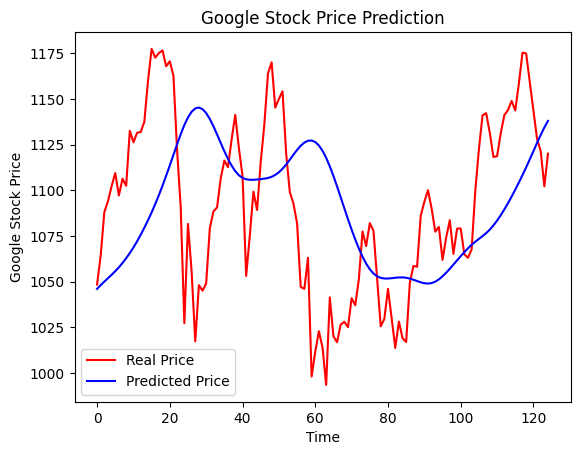

In [28]:
plt.plot(real_stock_price,color = 'red', label = 'Real Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()